# Выбор локации для скважины

## Цель исследования
Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

## Ход исследования
- Подготовка данных. На этом этапе будет проведены обзор, оценка качества данных, оценка возможности использовать данные для машинного обучения, предобработка данных.
- Обучение и проверка модели. На этом этапе выделим показатели, для обучения модели разделеним исходные данные на обучающую и тестовую выборки. Будем исследовать модель для достижения цели исследования.
- Подготовка к расчёту прибыли. Подсчитаем точку безубыточной разработки. Напишем функцию, в которой из полученных предсказаний будут выбираться 200 лучших для разработки скважин и считаться прибыль от их разработки.
- Расчёт прибыли и рисков. Рассчитаем среднее значение прибыли и риск убытков.

## Описание данных
Добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.


Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерено качество нефти и объём её запасов. 

Анализ возможной прибыли и рисков требуется реализовать с использованием техники *Bootstrap.*

Для выбора локации:

- В избранном регионе находят месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Признаки:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.



## Загрузка и подготовка данных

Создадим необходимое окружение для работы:

In [1]:
!pip install yellowbrick

     |████████████████████████████████| 282 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 44.8 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
!pip install pandas-profiling

     |████████████████████████████████| 325 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 13.4 MB/s eta 0:00:01
     |████████████████████████████████| 709 kB 11.5 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 54.4 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 46.1 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 71.1 MB/s eta 0:00:01
     |████████████████████████████████| 6.9 MB 32.2 MB/s eta 0:00:01
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=39e3459c0b742ce3de23ed3378822de395171ac360b5328f25a59b47a030e6d0
  Stored in directory: /home/jovyan/.cache/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
Successfully built htmlmin


In [3]:
import pandas as pd
import numpy as np
from yellowbrick.classifier import ClassificationReport
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler


### Ознакомление с данными
Загрузим исходные данные, создадим функции для получения ознакомительной информации.

In [4]:
df_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')


In [5]:
def data_report(initial_data):
    """
   функция отображает первые 10 строк на экран,
   выводит информацию о данных методом info, 
   создает расширенный отчет с помощью profile_report
   """
    display(initial_data.head(10))
    display(initial_data.info())
    report = initial_data.profile_report(title='MPG dataset analysis')
    display(report)

In [6]:
def data_report_2(initial_data):
    """
   функция отображает диаграммы размаха для заданных показателей
   """
    for column in ['f0', 'f1', 'f2', 'product']:
        sns.catplot(x=column, kind="box", data=initial_data, palette='husl')
        plt.title('Диаграмма размаха')
    plt.show()

Данные по 1-му региону:

In [7]:
data_report(df_1)

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
5  wX4Hy  0.969570  0.489775 -0.735383   64.741541
6  tL6pL  0.645075  0.530656  1.780266   49.055285
7  BYPU6 -0.400648  0.808337 -5.624670   72.943292
8  j9Oui  0.643105 -0.551583  2.372141  113.356160
9  OLuZU  2.173381  0.563698  9.441852  127.910945

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

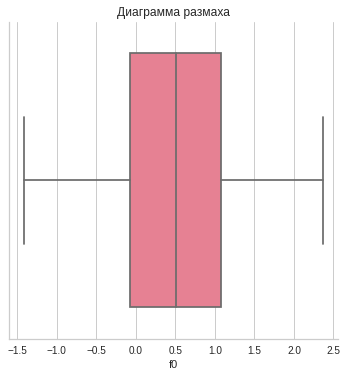

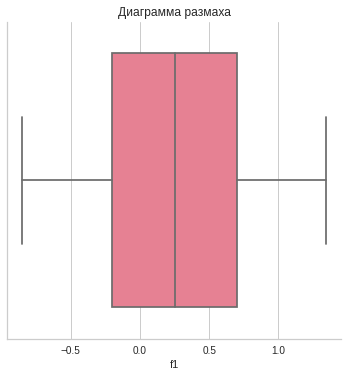

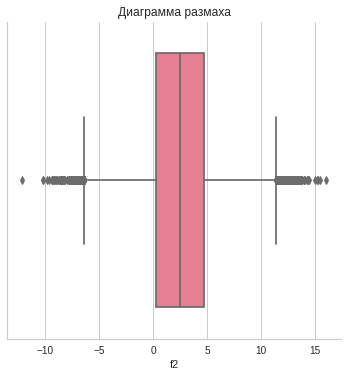

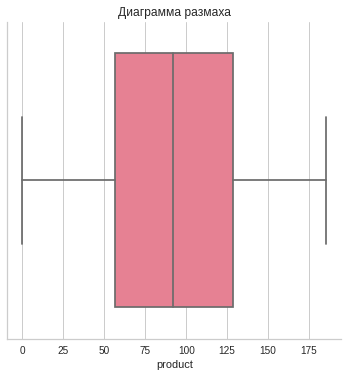

In [8]:
data_report_2(df_1)

Данные по 2-му региону:

In [9]:
data_report(df_2)

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
5  HHckp  -3.327590  -2.205276  3.003647   84.038886
6  h5Ujo -11.142655 -10.133399  4.002382  110.992147
7  muH9x   4.234715  -0.001354  2.004588   53.906522
8  YiRkx  13.355129  -0.332068  4.998647  134.766305
9  jG6Gi   1.069227 -11.025667  4.997844  137.945408

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

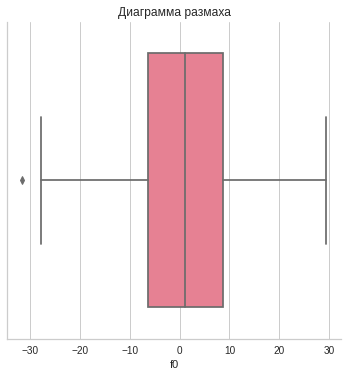

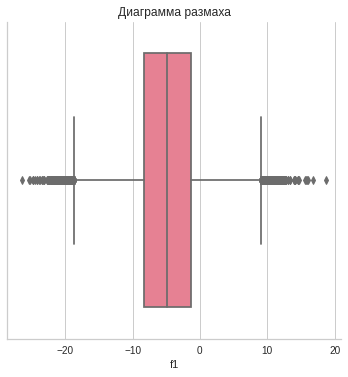

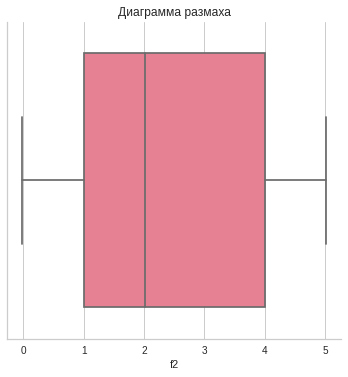

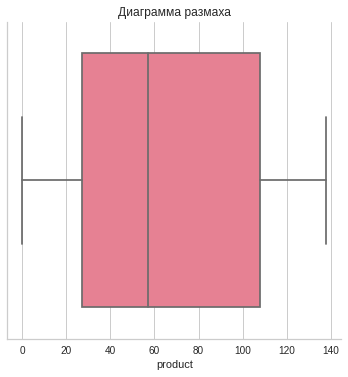

In [10]:
data_report_2(df_2)

Данные по 3-му региону:

In [11]:
data_report(df_3)

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
5  LzZXx -0.758092  0.710691  2.585887   90.222465
6  WBHRv -0.574891  0.317727  1.773745   45.641478
7  XO8fn -1.906649 -2.458350 -0.177097   72.480640
8  ybmQ5  1.776292 -0.279356  3.004156  106.616832
9  OilcN -1.214452 -0.439314  5.922514   52.954532

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

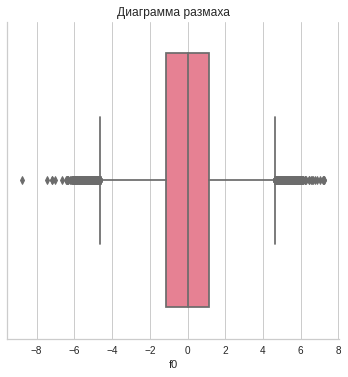

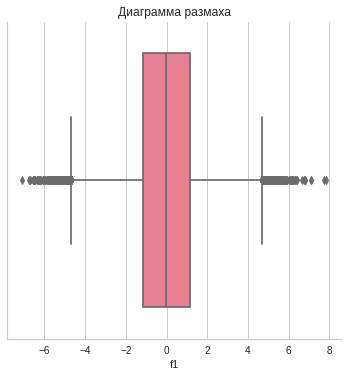

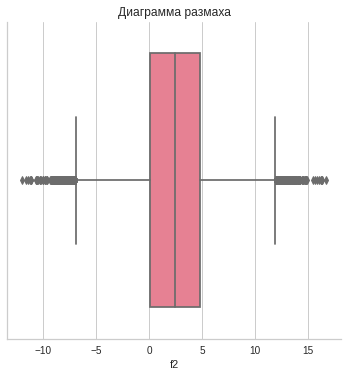

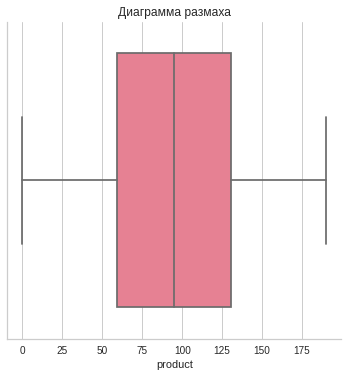

In [12]:
data_report_2(df_3)

### Итоги ознакомления с данными

После ознакомления с данными выделяем следующее:

- Мы имеем дело с данными по трем регионам, которые содержат 5 признаков из которых целевой признак product — объём запасов в скважине (тыс. баррелей). Типы переменных: числовых - 4, категориальных - 1. Количество наблюдений - 100000.
- Пропуски отсутствуют.
- Отсутствуют дубликаты.
- При подробном анализе значений признаков можно сделать следующие вывод: в рамках поставленной задачи признак id (уникальный идентификатор скважины)- нам не потребуются.
- При проверке на мультиколлинеарность — не было выявлено наличия сильной корреляции между несколькими не целевыми признаками для всех регионов.
- Масштабы распределений признаков f0, f1, f2 не сильно отличаются друг от друга (меньше одного порядка). Нет необходимости применять масштабирование.


Более подробное рассмотрение особеностей каждого региона:
- Регион 1. Самая большой коэффициент корреляции у целевого признака - product с признаком f2 умеренная корреляция, также есть слабая взаимосвязь с остальными признаками. Только значения признака f2 имеют нормальное распределение, присутствуют выбросы. У прочих признаков не наблюдается нормального распределения.  Распределение значений целевого признака product не нормально, имеется несколько выраженных пиков.
- Регион 2. Самая большой коэффициент корреляции у целевого признака - product с признаком f2(сильная корреляция). Значения столбца product, как и f2, четко разделены на 6 парных групп примерно одинакового размера. Только значения признака f1 имеют нормальное распределение, присутствуют выбросы. У прочих признаков не наблюдается нормального распределения. 
- Регион 3. Самая большой коэффициент корреляции у целевого признака - product с признаком f2 умеренная корреляция, также есть слабая взаимосвязь с остальными признаками. Значения всех признаков, кроме целевого имеют нормальное распределение, присутствуют выбросы.   Распределение значений целевого признака product не нормально, имеется несколько выраженных пиков.

Потребуется:
- удалить признак id (уникальный идентификатор скважины) из всех датасетов.

### Предобработка данных
Во всех датасетах избавимся от столбца id. 

In [13]:
def data_drop(data_for_preprocessing):
    """
   функция удаляет столбец 'id' в датасете
   """
    return data_for_preprocessing.drop(['id'], axis=1).copy()


Перезапишем данные.

In [14]:
data_1 = data_drop(df_1)

In [15]:
data_2 = data_drop(df_2)

In [16]:
data_3 = data_drop(df_3)

### Итоги предобработки
Получены наборы данных, которые можно использовать в машинном обучении.

### Итоги подготовки данных
На данном этапе было получено общее представление о данных по трем регионам. Потребовалась предобработка данных в виде исключения  столбца id из всех датасетов, так как не содержал информации полезной для данного исследования. В результате исследования получены наборы данных, применимые для анализа. 

Дальнейшие шаги для каждого набора данных:
- в данных выделить целевые признаки и целевую переменную,
- данные разделить на тренировочную и тестовую выборки;
- обучить модель и получаем предсказания на тестовой выборке.

## Обучение и проверка модели

Целевым признаком является product — объём запасов в скважине (тыс. баррелей). Данные по каждому региону разделим на обучающую и тестовую выборки в соотношении 75/25. Будем обучать модель LinearRegression. Рассчитаем: предсказанный средний объем запасов на месторождение(тыс. баррелей), реальный средний объем запасов в тестовой выборке (тыс. баррелей), cреднеквадратическую ошибку (RMSE) —  метрику, которая говорит нам, насколько далеко в среднем наши прогнозируемые значения от наших наблюдаемых значений в модели.

In [17]:
#для удобства вывода в дальнейшем - соберем показатели в списки
predictions_score = []
actuals_score = []
MRSE_score = []
region_name = []

In [18]:
def predictions(data_for_predictions):
    """
   функция разделяет данные: на целевые признаки и целевую переменную,
   на тренировочную и тестовую выборки; трансформирует признаки;
   обучает модель, получает предсказания для тестовой выборки и RMSE.
   Возвращает RMSE, предсказания и реальные значения
   """
    X = data_for_predictions.drop('product', axis= 1)
    Y = data_for_predictions['product']
    
    features_train, features_test, targets_train, targets_test = train_test_split(X, Y, 
                                                                                  test_size = 0.25, random_state = 42)
    
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_test = scaler.transform(features_test)

    model = LinearRegression()
    model.fit(features_train, targets_train)
    predictions = model.predict(features_test)
    predictions = predictions.round(decimals = 3)
    RMSE = (mean_squared_error(targets_test, predictions)**0.5)
    predictions = pd.Series(predictions)
    predictions.index = targets_test.index
    
    return RMSE, predictions, targets_test
    

In [19]:
RMSE_1, predictions_1, actuals_1 = predictions(data_1)
print(f'''Для региона 1: 
    Предсказанный средний объем запасов на месторождение: {predictions_1.mean():.2f} тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: {actuals_1.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_1:.2f}''')
predictions_score.append(predictions_1.mean())
actuals_score.append(actuals_1.mean())
MRSE_score.append(RMSE_1)
region_name.append("region_1")

Для региона 1: 
    Предсказанный средний объем запасов на месторождение: 92.40 тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: 92.33 тыс. баррелей,
    RMSE: 37.76


In [20]:
RMSE_2, predictions_2, actuals_2 = predictions(data_2)
print(f'''Для региона 2: 
    Предсказанный средний объем запасов на месторождение: {predictions_2.mean():.2f} тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: {actuals_2.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_2:.2f}''')
predictions_score.append(predictions_2.mean())
actuals_score.append(actuals_2.mean())
MRSE_score.append(RMSE_2)
region_name.append("region_2")

Для региона 2: 
    Предсказанный средний объем запасов на месторождение: 68.71 тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: 68.73 тыс. баррелей,
    RMSE: 0.89


In [21]:
RMSE_3, predictions_3, actuals_3 = predictions(data_3)
print(f'''Для региона 3: 
    Предсказанный средний объем запасов на месторождение: {predictions_3.mean():.2f} тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: {actuals_3.mean():.2f} тыс. баррелей,
    RMSE: {RMSE_3:.2f}''')
predictions_score.append(predictions_3.mean())
actuals_score.append(actuals_3.mean())
MRSE_score.append(RMSE_3)
region_name.append("region_3")

Для региона 3: 
    Предсказанный средний объем запасов на месторождение: 94.77 тыс. баррелей, 
    Реальный средний объем запасов в тестовой выборке: 95.15 тыс. баррелей,
    RMSE: 40.15


Рассмотрим сводную таблицу.

In [22]:
table_of_regions = (pd.DataFrame({'Наименование региона':region_name,\
                                  'Предсказанный средний объем запасов на месторождение':predictions_score,\
                                  'RMSE':MRSE_score,\
                                  'Реальный средний объем запасов':actuals_score, }).
                         sort_values(by='RMSE', ascending=True).
                  reset_index(drop=True))
table_of_regions

Наименование региона  Предсказанный средний объем запасов на месторождение  \
0             region_2                                          68.712878      
1             region_1                                          92.398802      
2             region_3                                          94.771024      

        RMSE  Реальный средний объем запасов  
0   0.890280                       68.725381  
1  37.756602                       92.325956  
2  40.145871                       95.150999

Сформируем словарь для дальнейшей работы.

In [23]:
data_all = {1: [predictions_1, actuals_1],
       2: [predictions_2, actuals_2],
       3: [predictions_3, actuals_3]}

### Итоги обучения и проверка модели

RMSE — полезный способ увидеть, насколько хорошо модель соответствует набору данных. Чем больше RMSE, тем больше разница между прогнозируемыми и наблюдаемыми значениями, а это означает, что модель хуже соответствует данным. И наоборот, чем меньше RMSE, тем лучше модель соответствует данным. Для целей нашего исследования мы сравнивали RMSE трех разных регионов и выявили, что лучше всего LinearRegression работает со вторым регионом. Такой результат объясняется сильной корреляцией целевого признака product с признаком f2.


## Подготовка к расчёту прибыли

Ключевые значения для расчётов прибыли:

При разведке региона исследуют 500 точек (N_SPOTS), из которых с помощью машинного обучения выбирают 200 лучших для разработки(N_BEST_SPOTS).

Бюджет на разработку скважин в регионе — 10 млрд рублей(BUDGET).

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей(INCOME_PER_UNIT).

После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [24]:
BUDGET = 10**10
N_SPOTS = 500
N_BEST_SPOTS = 200
INCOME_PER_UNIT = 450000

In [25]:
print('Для безубыточной разработки {} скважин нужно получить в среднем по {:.2f} тыс. баррелей с каждой'
      .format(N_BEST_SPOTS, BUDGET/INCOME_PER_UNIT/N_BEST_SPOTS))

Для безубыточной разработки 200 скважин нужно получить в среднем по 111.11 тыс. баррелей с каждой


Создадим функцию, в которой из полученных предсказаний будут выбираться 200 лучших для разработки скважин и считаться прибыль от их разработки.

In [26]:
def profit(actual, predicted):
    top200 = predicted.sort_values(ascending=False).head(N_BEST_SPOTS).index
    profit = (actual[top200].sum()*INCOME_PER_UNIT)-BUDGET
    
    return profit

### Итоги подготовки к расчёту прибыли
На данном этапе рассчитана точка безубыточной разработки 200 скважин: нужно получить в среднем по 111.11 тыс. баррелей с каждой скважины. Создана функция которая выбирает 200 лучших для разработки скважин и считаться прибыль от их разработки.

Дальнейшие действия:
- получим среднее значение прибыли для каждого региона (млн. руб);
- подсчитаем риск убытков составляет (%);
- на основании полученных данных выберем потенциально прибыльный регион.

## Расчёт прибыли и рисков 

Расчитаем прибыль и риски во всех регионах.

In [27]:
key = 1
# словарь для хранения данных
profits_distributions = {}
for prediction, target in data_all.values():
    profits_distributions[key] = []
    # перебирая предсказния и действительные значения, сохранённые ранее выполняем бутстреп 1000 раз,
    # считаем возможную выручку для каждого региона и получаем распределение значений
    state = RandomState(42)
    values = []
    for i in range(1000):
        data_sample = prediction.sample(n = N_SPOTS, replace = True, random_state=state)
        values.append(profit(target, data_sample))
    values = pd.Series(values)
    values = values
    #риск вычисляем как долю отрицательных значений от общего количества значений 
    risk = (values < 0).mean()*100
    # доверительный интервал вычисляем, взяв квантили
    confidence_interval = []
    confidence_interval.append(round(values.quantile(.025)/1e6, 1))
    confidence_interval.append(round(values.quantile(.975)/1e6, 1))
    # добавляем полученный набор в словарь
    profits_distributions[key].append(values)
    profits_distributions[key].append(risk)
    profits_distributions[key].append(confidence_interval)
    profits_distributions[key].append(values.mean())
    key +=1
    

In [28]:
for key in range(1,4):
    print('''Для региона {}:
    \tСреднее значение прибыли: {:.1f} млн. руб;
    \t95% доверительный интервал : {} (млн. руб)
    \tРиск убытков составляет {:.1f}%'''.format(key, (profits_distributions[key][3])/1e6,\
                                                profits_distributions[key][2],\
                                                profits_distributions[key][1] ))
    key +=1

Для региона 1:
    	Среднее значение прибыли: 399.5 млн. руб;
    	95% доверительный интервал : [-115.7, 897.5] (млн. руб)
    	Риск убытков составляет 6.0%
Для региона 2:
    	Среднее значение прибыли: 452.0 млн. руб;
    	95% доверительный интервал : [61.7, 845.3] (млн. руб)
    	Риск убытков составляет 1.5%
Для региона 3:
    	Среднее значение прибыли: 375.0 млн. руб;
    	95% доверительный интервал : [-144.8, 888.4] (млн. руб)
    	Риск убытков составляет 8.0%


### Итоги расчёта прибыли и рисков 
Для региона 1 и региона 3 были получены высокие значения риска убытков > 2.5%. Данные регионы не следует рассматривать для получения наибольшей прибыли в результате добычи. 

Риск убытков региона 2, чей риск ниже требуемого (соответствует условию  Риск < 2.5%). Кроме того доверительный интервал показывает, что разработка скважин окупится, так как риск убытков минимален в сравнении с другими регионами, и в случае убытков потери относительно невелики; является самым предсказуемым для моделирования;п оказал самое высокое значение потенциальной выручки.


## Общий вывод

В результате ознакомления с данными было установлено, что данные по трем регионам, содержат 5 признаков из которых целевой признак product — объём запасов в скважине (тыс. баррелей). Типы переменных: числовые - 4, категориальный - 1. Количество наблюдений - 100000. В данных отсутствуют пропуски и дубликаты. В рамках поставленной задачи признак id (уникальный идентификатор скважины)- нам не потребовался. Не выявлена мультиколлинеарность.Нет необходимости применять масштабирование.
- Регион 1. Самая большой коэффициент корреляции у целевого признака - product с признаком f2 умеренная корреляция, также есть слабая взаимосвязь с остальными признаками. Только значения признака f2 имеют нормальное распределение, присутствуют выбросы. У прочих признаков не наблюдается нормального распределения. Распределение значений целевого признака product не нормально, имеется несколько выраженных пиков.
- Регион 2. Самая большой коэффициент корреляции у целевого признака - product с признаком f2(сильная корреляция). Значения столбца product, как и f2, четко разделены на 6 парных групп примерно одинакового размера. Только значения признака f1 имеют нормальное распределение, присутствуют выбросы. У прочих признаков не наблюдается нормального распределения.
- Регион 3. Самая большой коэффициент корреляции у целевого признака - product с признаком f2 умеренная корреляция, также есть слабая взаимосвязь с остальными признаками. Значения всех признаков, кроме целевого имеют нормальное распределение, присутствуют выбросы. Распределение значений целевого признака product не нормально, имеется несколько выраженных пиков.


Потребовалась предобработка данных в виде исключения столбца id из всех датасетов, так как не содержал информации полезной для данного исследования. В результате исследования получены наборы данных, применимые для анализа.

В результате обучения модели LinearRegression рассчитаели: предсказанный средний объем запасов на месторождение(тыс. баррелей), реальный средний объем запасов в тестовой выборке (тыс. баррелей) и RMSE — полезный способ увидеть, насколько хорошо модель соответствует набору данных. Чем больше RMSE, тем больше разница между прогнозируемыми и наблюдаемыми значениями, а это означает, что модель хуже соответствует данным. И наоборот, чем меньше RMSE, тем лучше модель соответствует данным. Для целей нашего исследования мы сравнивали RMSE трех разных регионов и выявили, что лучше всего LinearRegression работает со вторым регионом. Такой результат объясняется сильной корреляцией целевого признака product с признаком f2.


In [29]:
table_of_regions = (pd.DataFrame({'Наименование региона':region_name,\
                                  'Предсказанный средний объем запасов на месторождение':predictions_score,\
                                  'RMSE':MRSE_score,\
                                  'Реальный средний объем запасов':actuals_score, }).
                         sort_values(by='RMSE', ascending=True).
                  reset_index(drop=True))
table_of_regions

Наименование региона  Предсказанный средний объем запасов на месторождение  \
0             region_2                                          68.712878      
1             region_1                                          92.398802      
2             region_3                                          94.771024      

        RMSE  Реальный средний объем запасов  
0   0.890280                       68.725381  
1  37.756602                       92.325956  
2  40.145871                       95.150999

Расчёта прибыли и рисков показал следующие результаты:
- Для региона 1:cреднее значение прибыли: 399.5 млн. руб; риск убытков составляет 6.0%;
- Для региона 2:среднее значение прибыли: 452.0 млн. руб; риск убытков составляет 1.5%;
- Для региона 3:cреднее значение прибыли: 375.0 млн. руб; риск убытков составляет 8.0%

Для региона 1 и региона 3 были получены высокие значения риска убытков > 2.5%. Данные регионы не следует рассматривать для получения наибольшей прибыли в результате добычи. 

Региона 2, чей риск ниже требуемого, соответствует условию  Риск < 2.5%. Кроме того доверительный интервал показывает, что разработка скважин окупится, так как риск убытков минимален в сравнении с другими регионами, и в случае убытков потери относительно невелики; является самым предсказуемым для моделирования;п оказал самое высокое значение потенциальной выручки.

В результате проделанной работы была построена модель машинного обучения LinearRegression, которая помогла определить регион, где добыча принесёт наибольшую прибыль. Таким регионом на основании расчетов выбран регион 2.